# In this notebook we test several convolutional architectures to classify images for presence/absence of BP 

Notes:
+ current best accuracy is 81.3 %
+ notebook presentation is good for sharing ideas but I need to make python script for effieicient termnal based training of networks

## Create trainining and validation set 

In [35]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
import BP_preprocess
reload (BP_preprocess)

<module 'BP_preprocess' from '/Users/afinneg2/BP_identification/scripts/BP_preprocess.py'>

In [78]:
### Keras functions/ modules

from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras import backend as K
## a function to convert (dataset_size) array with elements indicating
## target category to a (dataset_size, nb_category) array where
## [i,:] is an indictor vector for target class of ith example
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import theano
import theano.tensor as T
from keras.regularizers import l2,l1
from keras.models import model_from_json

## Load training data and preprocess

In [5]:
# load training data############
dataDir = '/Users/afinneg2/BP_identification'
####################################

os.chdir(dataDir)
train_imgs= np.load('imgs_train.npy')
print 'shape train_imgs {}'.format(np.shape(train_imgs))
train_masks = np.load('imgs_mask_train.npy')
print 'shape train_mask {}'.format(np.shape(train_masks))

shape train_imgs (5635, 1, 420, 580)
shape train_mask (5635, 1, 420, 580)


In [9]:
###  image resize  parameters  #######
resized_rows = 64
resized_cols= 80
interp_method ='INTER_AREA'
#################################

train_imgs = BP_preprocess.resize_images(train_imgs,
                        resized_rows, resized_cols, interp_method='INTER_AREA')
train_masks = BP_preprocess.resize_images(train_masks,
                        resized_rows, resized_cols, interp_method='INTER_AREA')


print "old shape of training imgaes {}".format(np.shape(train_imgs))
print  "old shape of training masks {}".format(np.shape(train_masks))

train_masks =np.squeeze(train_masks, axis=1)  # squeeze out lenth 1 dimension 
train_imgs = BP_preprocess.mean_center_and_scale(train_imgs)

print "new shape of training imgaes {}".format(np.shape(train_imgs))
print  "new shape of training masks {}".format(np.shape(train_masks))

old shape of training imgaes (5635, 1, 64, 80)
old shape of training masks (5635, 1, 64, 80)
new shape of training imgaes (5635, 64, 80)
new shape of training masks (5635, 64, 80)


## Balance the training set and set aside images for validation

In [19]:
## get indices of images positive for BP ######
pos_mask = np.asarray([BP_preprocess.mask_not_blank(mask) for mask in train_masks])
neg_mask = np.logical_not(pos_mask)

nbPosImgs=np.count_nonzero(pos_mask)
nbNegImgs  = np.count_nonzero(neg_mask)

print "number images positive for BP {}".format(nbPosImgs)
print "number imgaes negatve for BP {}".format(nbNegImgs)
print "fraction positive {:.3f}".format(nbPosImgs/np.float(
                                              nbPosImgs +  nbNegImgs ))

number images positive for BP 2323
number imgaes negatve for BP 3312
fraction positive 0.412


In [39]:
#### training and validation set partition parameters ####
trainSetSize = 42*(10**2)
saveArrDir='/Users/afinneg2/BP_identification/TrainValidPartitions/attempt1/'
#################################################
PosIndices = np.nonzero(pos_mask)[0]
NegIndices = np.nonzero(neg_mask)[0]

print "shape of PosIndies {}".format(np.shape(PosIndices))
print "shape of negIndies {}".format(np.shape(NegIndices)) 

TrainIndices, ValidIndices= BP_preprocess.TrainingValditionIndexPartition(
                                PosIndices, NegIndices, trainSetSize,
                                PosElemsLimiting=True)  
    
TrainPosIndices, TrainNegIndices = TrainIndices

ValidPosIndices, ValidNegIndices = ValidIndices

np.save(os.path.join(saveArrDir,'TrainPosIndices') , TrainPosIndices )
np.save(os.path.join(saveArrDir,'TrainNegIndices') , TrainNegIndices )
np.save(os.path.join(saveArrDir,'ValidPosIndices') , ValidPosIndices )
np.save(os.path.join(saveArrDir,'ValidNegIndices') , ValidNegIndices )

shape of PosIndies (2323,)
shape of negIndies (3312,)
shape of TrainPosIndices (2100,)
shape of TrainNegIndices (2100,)
shape of ValidPosIndices (223,)
shape of ValidNegIndices (223,)


## Build the training and validation sets

In [43]:
train_X = np.vstack([train_imgs[TrainPosIndices] , train_imgs[TrainNegIndices]] )
train_X = np.reshape(train_X , newshape=(4200,1,64,80) )             
train_Y = to_categorical(
                np.hstack(
                    [np.ones(shape=(len(TrainPosIndices),), dtype = int ),
                    np.zeros(shape=(len(TrainNegIndices),), dtype = int )]
                        ) , nb_classes=2) 

valid_X = np.vstack([train_imgs[ValidPosIndices] , train_imgs[ValidNegIndices] ])
valid_X = np.reshape(valid_X , newshape=(446,1,64,80) )  
valid_Y = to_categorical(
                np.hstack(
                    [np.ones(shape=(len(ValidPosIndices),), dtype = int ),
                    np.zeros(shape=(len(ValidNegIndices),), dtype = int )]
                        ) , nb_classes=2)

print np.shape(train_X)
print np.shape(train_Y)
print np.shape(valid_X)
print np.shape(valid_Y)

(4200, 1, 64, 80)
(4200, 2)
(446, 1, 64, 80)
(446, 2)


#  Test Several Convolutional architectures and training parameters

## Test a (20,4,4) conv ->pool (2,2)  -> conv (50,5,7) -> maxpool (2,2) -> 2x dense 200 unit -> classifier network

Notes:
+ (50, 5 ,7 ) conv := 50 feature maps with connections to (rows = 5, cols = 7) unit patches of previous layer/ input
 
+ dense 200 := 200 units fully connected to previous layer
+  dropout of p=0.2 for 1st conv, then p=0.5 upto but not including the softmax classification layer

In [81]:
inputs = Input(shape=(1,64,80),name='inputs')

x = Convolution2D(20,4, 4, input_shape=(1,64,80),
                  activation='relu', 
                  border_mode='valid',
                  name='conv1')(inputs)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool1')(x)
x=Dropout(p=0.2)(x)

x =  Convolution2D(50,5, 7,
                  activation='relu', 
                  border_mode='valid',
                  name='conv2')(x)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool2')(x)
x=Dropout(p=0.5)(x)
x= Flatten(name ='flatten')(x)

x = Dense(200, activation='tanh',name='dense1', init='he_normal')(x)
x=Dropout(p=0.5)(x)
x = Dense(200, activation='tanh',name='dense2', init='he_normal')(x)
  
predictions = Dense(2, activation='softmax', name='output')(x)

model =Model(input=inputs, output= predictions)
#sgd= SGD(lr = 0.01, momentum=0.9, nesterov=True)
adam = Adam()

model.compile(loss = 'categorical_crossentropy', optimizer=adam,
             metrics=['accuracy'])

In [82]:
# fit the model 2 cov layer + 2  fc layer
early_stoppping = EarlyStopping(monitor='val_loss', patience=40, mode='auto')
model.fit(train_X, train_Y, validation_data=[valid_X, valid_Y], nb_epoch=50,
          callbacks=[early_stoppping])

Train on 4200 samples, validate on 446 samples
Epoch 1/50
4200/4200 [==============================] - 28s - loss: 0.6638 - acc: 0.6271 - val_loss: 0.5799 - val_acc: 0.6570
Epoch 2/50
4200/4200 [==============================] - 28s - loss: 0.5762 - acc: 0.6914 - val_loss: 0.5717 - val_acc: 0.7040
Epoch 3/50
4200/4200 [==============================] - 28s - loss: 0.5540 - acc: 0.7052 - val_loss: 0.5470 - val_acc: 0.7175
Epoch 4/50
4200/4200 [==============================] - 28s - loss: 0.5503 - acc: 0.7210 - val_loss: 0.6028 - val_acc: 0.6726
Epoch 5/50
4200/4200 [==============================] - 28s - loss: 0.5388 - acc: 0.7286 - val_loss: 0.5350 - val_acc: 0.7152
Epoch 6/50
4200/4200 [==============================] - 28s - loss: 0.5206 - acc: 0.7424 - val_loss: 0.5238 - val_acc: 0.7220
Epoch 7/50
4200/4200 [==============================] - 28s - loss: 0.5161 - acc: 0.7429 - val_loss: 0.5196 - val_acc: 0.7489
Epoch 8/50
4200/4200 [==============================] - 28s - loss: 0.4

KeyboardInterrupt: 

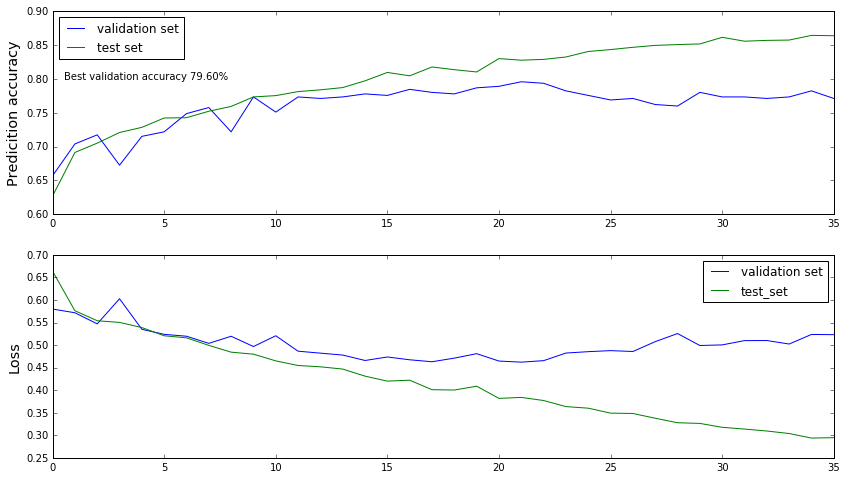

In [101]:
%matplotlib inline
figsize = (14,8)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(2,1,1)
ax.plot(model.history.history['val_acc'], label = 'validation set')
ax.plot(model.history.history['acc'], label = 'test set')
ax.set_ylabel('Predicition accuracy', fontsize='x-large')
ax.text(0.5,0.8, "Best validation accuracy {:.2%}".format(
                                max(model.history.history['val_acc'])
                                            )
        )
ax.legend(loc=0)


ax = fig.add_subplot(2,1,2)
ax.plot(model.history.history['val_loss'], label = 'validation set')
ax.plot(model.history.history['loss'], label = 'test_set')
ax.set_ylabel('Loss',fontsize='x-large')
ax.legend(loc=0)

Conclusions:
+  best accuracy on validation set us 79.6 %
+  significant overfitting seems to start at ~80% test set accuracy
                    

Things to try:
+ To fight overfitting:
    + data set expansion ( will almost certainly help)
        + possible methods:
            + generatate multiple training inputs from one image by adding noise 
                + with what intensity ?
                + should intensity be uniform across image?
            +  generate multiple training inputs from one image:
                + could we perturb images by simulating small variations in the orientation of the ultrasound receiver?
                + Dmitrii had code to create continuous movie of the images, could we use this to interpolate intermediate frames and add these frames to the data set?
                
    + Regularize the weights
        + common method is l2 regularization of weights
            + I have tested l2 regularization below with sight improvement
            + but many choices for l2 params 
                + actual value l2 param used  below 0.01 but this parameter can vary by layer.
                    + should we use it only in the convolutional layers? (my intuition is yes but thats not what i do below)
        + more sophisticated regularization
            + using l2 reg amounts to puting a prior probability on the distribution of weights
            + l2 reg corresponds to a weight-wise gaussian prior, there are probably other priors that are better for the first convolutional layer that will bias filters towards slow varying features in image rather than noise. Does anyone have ideas about how to define or implement these
      
    + incorporate weights that are specifically initiated based on analysis of training data images 
        + in another notebook I worked on doing pca over subregions of the training images and then finding the PC vectors that do the best job discriminating between elements of the positive and negative dataset (this is done be looking at distributions of positive and negative images onto the PC component and then selecting the PC vectors for which these distributions have the larges Jenson Shannon Divergence
        
+ keras model.fit() method allows for weighting the loss function by class.
    + use this method to include all the negative data (rather than excluding some to balance the train set) by reweighting classes inversely proportional to their abundance in the full data set
    

### Test a (20,4,4) conv ->pool (2,2)  -> conv (50,5,7) -> maxpool (2,2) -> 1x dense 200 unit -> classifier network

Notes:
+  we are interested in comparing the training time for this slightly simpler network to that for network with 2 dense layers
+  dropout of p=0.2 for 1st conv, then p=0.5 upto but not including the softmax classification layer

In [102]:
inputs = Input(shape=(1,64,80),name='inputs')

x = Convolution2D(20,4, 4, input_shape=(1,64,80),
                  activation='relu', 
                  border_mode='valid',
                  name='conv1')(inputs)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool1')(x)
x=Dropout(p=0.2)(x)

x =  Convolution2D(50,5, 7,
                  activation='relu', 
                  border_mode='valid',
                  name='conv2')(x)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool2')(x)
x=Dropout(p=0.5)(x)
x= Flatten(name ='flatten')(x)

x = Dense(200, activation='tanh',name='dense1', init='he_normal')(x)
 
predictions = Dense(2, activation='softmax', name='output')(x)

model =Model(input=inputs, output= predictions)
#sgd= SGD(lr = 0.01, momentum=0.9, nesterov=True)
adam = Adam()

model.compile(loss = 'categorical_crossentropy', optimizer=adam,
             metrics=['accuracy'])

In [104]:
# fit the model 
early_stoppping = EarlyStopping(monitor='val_loss', patience=10, mode='auto')
model.fit(train_X, train_Y, validation_data=[valid_X, valid_Y], nb_epoch=3,
          callbacks=[early_stoppping])

Train on 4200 samples, validate on 446 samples
Epoch 1/3
4200/4200 [==============================] - 28s - loss: 0.5968 - acc: 0.6902 - val_loss: 0.5778 - val_acc: 0.6906
Epoch 2/3
4200/4200 [==============================] - 28s - loss: 0.5867 - acc: 0.6952 - val_loss: 0.5756 - val_acc: 0.7108
Epoch 3/3
4200/4200 [==============================] - 28s - loss: 0.5719 - acc: 0.7183 - val_loss: 0.5606 - val_acc: 0.7220


Conclusions:  training the 2 convolutional, 1 dense network takes ~28 s per epoch as opposed to 29-30 s for 2 conv 2 dense network. 

Since there is such little difference in train time / epoch choose to focus on the network with 2 dense layers

## Test a (20,4,4) conv ->pool (2,2)  -> conv (50,5,7) -> maxpool (2,2) -> 2x dense 200 unit -> classifier network
(same network as above but with l2 regularization param 0.01) 


In [107]:
inputs = Input(shape=(1,64,80),name='inputs')     

x = Convolution2D(20,4, 4, input_shape=(1,64,80),
                  activation='relu', 
                  border_mode='valid',
                  name='conv1', 
                  W_regularizer = l2(l=0.01))(inputs)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool1')(x)
x=Dropout(p=0.2)(x)

x =  Convolution2D(50,5, 7,
                  activation='relu', 
                  border_mode='valid',
                  name='conv2',
                W_regularizer = l2(l=0.01))(inputs)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool2')(x)
x=Dropout(p=0.5)(x)
x= Flatten(name ='flatten')(x)

x = Dense(200, activation='tanh',
          name='dense1', init='he_normal', W_regularizer= l2(l=0.01) )(x)
x=Dropout(p=0.5)(x)
x = Dense(200, activation='tanh',
          name='dense2', init='he_normal', W_regularizer= l2(l=0.01))(x)
  
predictions = Dense(2, activation='softmax', name='output')(x)

model =Model(input=inputs, output= predictions)
#sgd= SGD(lr = 0.01, momentum=0.9, nesterov=True)
adam = Adam()

model.compile(loss = 'categorical_crossentropy', optimizer=adam,
             metrics=['accuracy'])

In [108]:
# fit the model 
early_stoppping = EarlyStopping(monitor='val_loss', patience=10, mode='auto')
model.fit(train_X, train_Y, validation_data=[valid_X, valid_Y], nb_epoch=50,
          callbacks=[early_stoppping])

Train on 4200 samples, validate on 446 samples
Epoch 1/50
4200/4200 [==============================] - 39s - loss: 4.3048 - acc: 0.6445 - val_loss: 0.5427 - val_acc: 0.7040
Epoch 2/50
4200/4200 [==============================] - 39s - loss: 1.9390 - acc: 0.7102 - val_loss: 0.5565 - val_acc: 0.7018
Epoch 3/50
4200/4200 [==============================] - 38s - loss: 1.2244 - acc: 0.7317 - val_loss: 0.5248 - val_acc: 0.7601
Epoch 4/50
4200/4200 [==============================] - 38s - loss: 0.9033 - acc: 0.7457 - val_loss: 0.5537 - val_acc: 0.7309
Epoch 5/50
4200/4200 [==============================] - 37s - loss: 0.8097 - acc: 0.7429 - val_loss: 0.4986 - val_acc: 0.7556
Epoch 6/50
4200/4200 [==============================] - 38s - loss: 0.7879 - acc: 0.7514 - val_loss: 0.4936 - val_acc: 0.7601
Epoch 7/50
4200/4200 [==============================] - 40s - loss: 0.7753 - acc: 0.7614 - val_loss: 0.4972 - val_acc: 0.7534
Epoch 8/50
4200/4200 [==============================] - 48s - loss: 0.7

KeyboardInterrupt: 

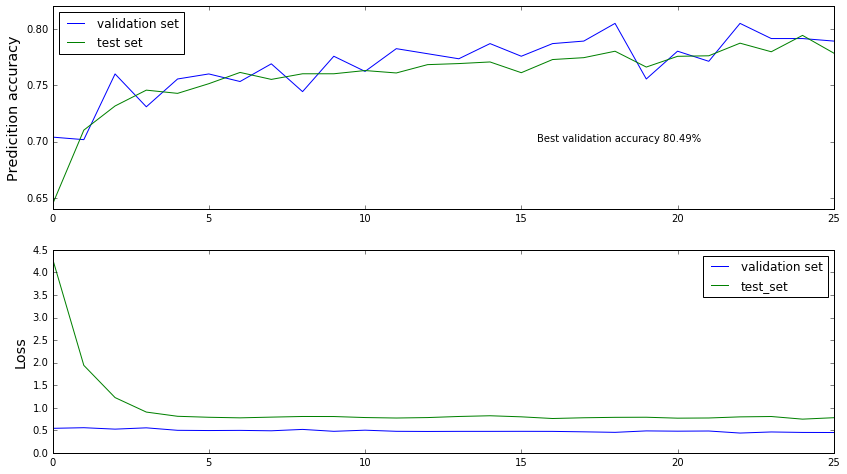

In [111]:
%matplotlib inline
figsize = (14,8)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(2,1,1)
ax.plot(model.history.history['val_acc'], label = 'validation set')
ax.plot(model.history.history['acc'], label = 'test set')
ax.set_ylabel('Predicition accuracy', fontsize='x-large')
ax.text(15.5,0.7, "Best validation accuracy {:.2%}".format(
                                max(model.history.history['val_acc'])
                                            )
        )
ax.legend(loc=0)


ax = fig.add_subplot(2,1,2)
ax.plot(model.history.history['val_loss'], label = 'validation set')
ax.plot(model.history.history['loss'], label = 'test_set')
ax.set_ylabel('Loss',fontsize='x-large')
ax.legend(loc=0)

## Test a (20,4,4) conv ->pool (2,2)  -> conv (50,5,7) -> maxpool (2,2) -> 2x dense 200 unit -> classifier network
(same network as above but with l2 regularization param 0.01 in colvolutional layers and l2 regularization params 10^(-4) in dense layers) 

In [112]:
inputs = Input(shape=(1,64,80),name='inputs')     

x = Convolution2D(20,4, 4, input_shape=(1,64,80),
                  activation='relu', 
                  border_mode='valid',
                  name='conv1', 
                  W_regularizer = l2(l=0.01))(inputs)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool1')(x)
x=Dropout(p=0.2)(x)

x =  Convolution2D(50,5, 7,
                  activation='relu', 
                  border_mode='valid',
                  name='conv2',
                W_regularizer = l2(l=0.01))(inputs)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool2')(x)
x=Dropout(p=0.5)(x)
x= Flatten(name ='flatten')(x)

x = Dense(200, activation='tanh',
          name='dense1', init='he_normal', W_regularizer= l2(l=0.0001) )(x)
x=Dropout(p=0.5)(x)
x = Dense(200, activation='tanh',
          name='dense2', init='he_normal', W_regularizer= l2(l=0.0001))(x)
  
predictions = Dense(2, activation='softmax', name='output')(x)

model =Model(input=inputs, output= predictions)
#sgd= SGD(lr = 0.01, momentum=0.9, nesterov=True)
adam = Adam()

model.compile(loss = 'categorical_crossentropy', optimizer=adam,
             metrics=['accuracy'])

In [113]:
# fit the model 
early_stoppping = EarlyStopping(monitor='val_loss', patience=10, mode='auto')
model.fit(train_X, train_Y, validation_data=[valid_X, valid_Y], nb_epoch=50,
          callbacks=[early_stoppping])

Train on 4200 samples, validate on 446 samples
Epoch 1/50
4200/4200 [==============================] - 40s - loss: 0.8007 - acc: 0.6245 - val_loss: 0.5230 - val_acc: 0.7354
Epoch 2/50
4200/4200 [==============================] - 38s - loss: 0.6793 - acc: 0.7412 - val_loss: 0.4757 - val_acc: 0.7691
Epoch 3/50
4200/4200 [==============================] - 39s - loss: 0.6464 - acc: 0.7776 - val_loss: 0.4881 - val_acc: 0.7601
Epoch 4/50
4200/4200 [==============================] - 39s - loss: 0.6365 - acc: 0.7983 - val_loss: 0.4461 - val_acc: 0.7915
Epoch 5/50
4200/4200 [==============================] - 38s - loss: 0.6272 - acc: 0.8171 - val_loss: 0.4960 - val_acc: 0.7668
Epoch 6/50
4200/4200 [==============================] - 38s - loss: 0.6228 - acc: 0.8286 - val_loss: 0.4909 - val_acc: 0.7960
Epoch 7/50
4200/4200 [==============================] - 38s - loss: 0.6247 - acc: 0.8383 - val_loss: 0.4714 - val_acc: 0.7780
Epoch 8/50
4200/4200 [==============================] - 38s - loss: 0.6

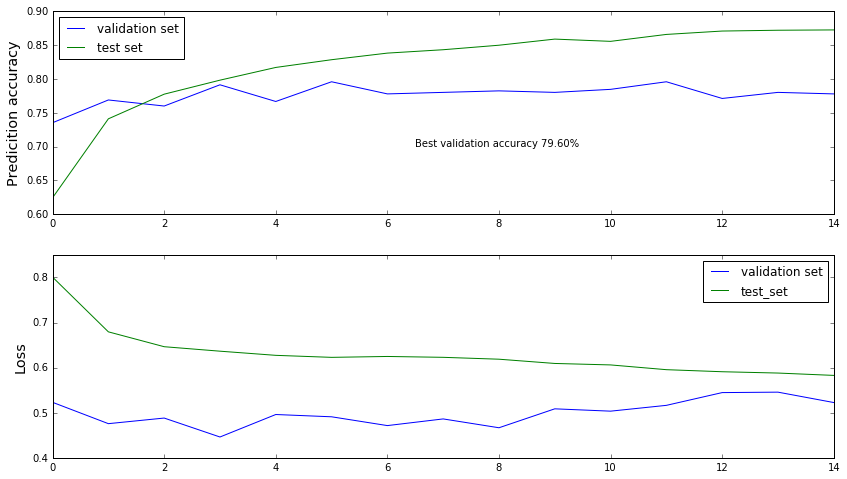

In [115]:
%matplotlib inline
figsize = (14,8)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(2,1,1)
ax.plot(model.history.history['val_acc'], label = 'validation set')
ax.plot(model.history.history['acc'], label = 'test set')
ax.set_ylabel('Predicition accuracy', fontsize='x-large')
ax.text(6.5,0.7, "Best validation accuracy {:.2%}".format(
                                max(model.history.history['val_acc'])
                                            )
        )
ax.legend(loc=0)


ax = fig.add_subplot(2,1,2)
ax.plot(model.history.history['val_loss'], label = 'validation set')
ax.plot(model.history.history['loss'], label = 'test_set')
ax.set_ylabel('Loss',fontsize='x-large')
ax.legend(loc=0)

Conclusion: the l2 reg param  10^(-4) for dense layers is too small (not enough regularization). Increase and try again

In [116]:
inputs = Input(shape=(1,64,80),name='inputs')     

x = Convolution2D(20,4, 4, input_shape=(1,64,80),
                  activation='relu', 
                  border_mode='valid',
                  name='conv1', 
                  W_regularizer = l2(l=0.01))(inputs)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool1')(x)
x=Dropout(p=0.2)(x)

x =  Convolution2D(50,5, 7,
                  activation='relu', 
                  border_mode='valid',
                  name='conv2',
                W_regularizer = l2(l=0.01))(inputs)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool2')(x)
x=Dropout(p=0.5)(x)
x= Flatten(name ='flatten')(x)

x = Dense(200, activation='tanh',
          name='dense1', init='he_normal', W_regularizer= l2(l=0.001) )(x)
x=Dropout(p=0.5)(x)
x = Dense(200, activation='tanh',
          name='dense2', init='he_normal', W_regularizer= l2(l=0.001))(x)
  
predictions = Dense(2, activation='softmax', name='output')(x)

model =Model(input=inputs, output= predictions)
#sgd= SGD(lr = 0.01, momentum=0.9, nesterov=True)
adam = Adam()

model.compile(loss = 'categorical_crossentropy', optimizer=adam,
             metrics=['accuracy'])

In [117]:
# fit the model 
early_stoppping = EarlyStopping(monitor='val_loss', patience=10, mode='auto')
model.fit(train_X, train_Y, validation_data=[valid_X, valid_Y], nb_epoch=50,
          callbacks=[early_stoppping])

Train on 4200 samples, validate on 446 samples
Epoch 1/50
4200/4200 [==============================] - 39s - loss: 1.4494 - acc: 0.6019 - val_loss: 0.5366 - val_acc: 0.7175
Epoch 2/50
4200/4200 [==============================] - 39s - loss: 1.1085 - acc: 0.7376 - val_loss: 0.4932 - val_acc: 0.7646
Epoch 3/50
4200/4200 [==============================] - 39s - loss: 0.9793 - acc: 0.7702 - val_loss: 0.4794 - val_acc: 0.7691
Epoch 4/50
4200/4200 [==============================] - 38s - loss: 0.9227 - acc: 0.7817 - val_loss: 0.4664 - val_acc: 0.7803
Epoch 5/50
4200/4200 [==============================] - 38s - loss: 0.8701 - acc: 0.7914 - val_loss: 0.4464 - val_acc: 0.7915
Epoch 6/50
4200/4200 [==============================] - 38s - loss: 0.8198 - acc: 0.7945 - val_loss: 0.4667 - val_acc: 0.7735
Epoch 7/50
4200/4200 [==============================] - 40s - loss: 0.7879 - acc: 0.7979 - val_loss: 0.4662 - val_acc: 0.7803
Epoch 8/50
4200/4200 [==============================] - 44s - loss: 0.7

KeyboardInterrupt: 

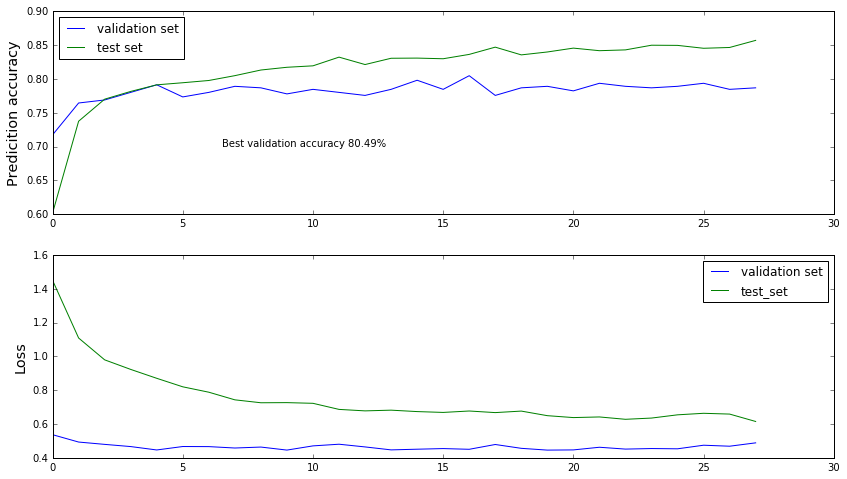

In [118]:
%matplotlib inline
figsize = (14,8)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(2,1,1)
ax.plot(model.history.history['val_acc'], label = 'validation set')
ax.plot(model.history.history['acc'], label = 'test set')
ax.set_ylabel('Predicition accuracy', fontsize='x-large')
ax.text(6.5,0.7, "Best validation accuracy {:.2%}".format(
                                max(model.history.history['val_acc'])
                                            )
        )
ax.legend(loc=0)


ax = fig.add_subplot(2,1,2)
ax.plot(model.history.history['val_loss'], label = 'validation set')
ax.plot(model.history.history['loss'], label = 'test_set')
ax.set_ylabel('Loss',fontsize='x-large')
ax.legend(loc=0)

Conclustion:
+ l2 regularization param of 0.001 for dense layers 

In [119]:
inputs = Input(shape=(1,64,80),name='inputs')     

x = Convolution2D(30,3, 3, input_shape=(1,64,80),
                  activation='relu', 
                  border_mode='valid',
                  name='conv1', 
                  W_regularizer = l2(l=0.01))(inputs)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool1')(x)
x=Dropout(p=0.2)(x)

x =  Convolution2D(50,5, 5,
                  activation='relu', 
                  border_mode='valid',
                  name='conv2',
                W_regularizer = l2(l=0.01))(inputs)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool2')(x)
x=Dropout(p=0.5)(x)

x =  Convolution2D(50,8, 10,
                  activation='relu', 
                  border_mode='valid',
                  name='conv3',
                W_regularizer = l2(l=0.01))(inputs)
x= MaxPooling2D(pool_size=(2,2), border_mode= 'valid', name='maxpool3')(x)
x=Dropout(p=0.5)(x)


x= Flatten(name ='flatten')(x)
x = Dense(200, activation='tanh',
          name='dense1', init='he_normal', W_regularizer= l2(l=0.001) )(x)
x=Dropout(p=0.5)(x)
x = Dense(200, activation='tanh',
          name='dense2', init='he_normal', W_regularizer= l2(l=0.001))(x)
  
predictions = Dense(2, activation='softmax', name='output')(x)

model =Model(input=inputs, output= predictions)
#sgd= SGD(lr = 0.01, momentum=0.9, nesterov=True)
adam = Adam()

model.compile(loss = 'categorical_crossentropy', optimizer=adam,
             metrics=['accuracy'])

In [120]:
# fit the model 
early_stoppping = EarlyStopping(monitor='val_loss', patience=10, mode='auto')
model.fit(train_X, train_Y, validation_data=[valid_X, valid_Y], nb_epoch=50,
          callbacks=[early_stoppping])

Train on 4200 samples, validate on 446 samples
Epoch 1/50
4200/4200 [==============================] - 38s - loss: 1.4332 - acc: 0.6290 - val_loss: 0.6698 - val_acc: 0.6166
Epoch 2/50
4200/4200 [==============================] - 37s - loss: 1.2280 - acc: 0.7145 - val_loss: 0.5283 - val_acc: 0.7309
Epoch 3/50
4200/4200 [==============================] - 37s - loss: 1.1416 - acc: 0.7457 - val_loss: 0.4988 - val_acc: 0.7646
Epoch 4/50
4200/4200 [==============================] - 36s - loss: 1.0153 - acc: 0.7745 - val_loss: 0.4799 - val_acc: 0.7713
Epoch 5/50
4200/4200 [==============================] - 36s - loss: 0.9388 - acc: 0.7921 - val_loss: 0.4841 - val_acc: 0.7713
Epoch 6/50
4200/4200 [==============================] - 36s - loss: 0.8864 - acc: 0.7905 - val_loss: 0.4816 - val_acc: 0.7691
Epoch 7/50
4200/4200 [==============================] - 36s - loss: 0.8228 - acc: 0.7990 - val_loss: 0.4562 - val_acc: 0.7915
Epoch 8/50
4200/4200 [==============================] - 38s - loss: 0.7

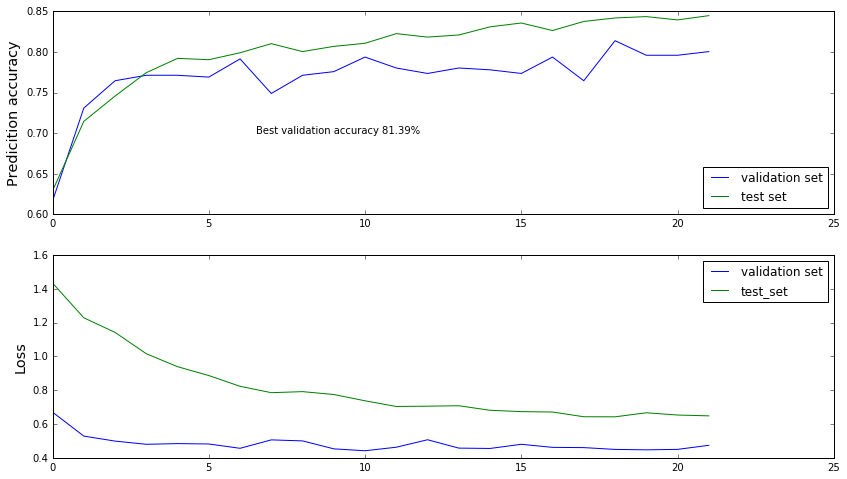

In [121]:
%matplotlib inline
figsize = (14,8)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(2,1,1)
ax.plot(model.history.history['val_acc'], label = 'validation set')
ax.plot(model.history.history['acc'], label = 'test set')
ax.set_ylabel('Predicition accuracy', fontsize='x-large')
ax.text(6.5,0.7, "Best validation accuracy {:.2%}".format(
                                max(model.history.history['val_acc'])
                                            )
        )
ax.legend(loc=0)


ax = fig.add_subplot(2,1,2)
ax.plot(model.history.history['val_loss'], label = 'validation set')
ax.plot(model.history.history['loss'], label = 'test_set')
ax.set_ylabel('Loss',fontsize='x-large')
ax.legend(loc=0)

Conclusions:
+ 3 convolutional layer architecture 0.9 % improvement 
+ Should extend number of training epochs by increasing the patience parameter may lead to still better performance

# current best classifer performance is 81.39 %
+ need a good method to turn the classification into an method for localizing the BP (so that the dice coeff (the scoring method) can be calculated )